In [1]:
%matplotlib inline
import json
import pandas as pd

In [2]:
# Read and return the "api_key" key from a JSON file
def read_key(fn):
    with open(fn) as json_file:
        data = json.load(json_file)
        return data["api_key"]

# Setup checklist:

  1. Make a new directory on your computer
  1. Download the entire repository for this workshop as a .zip from https://github.com/dsiufl/DataAPIs-Workshop/archive/master.zip
  1. Extract it to the new directory. You should see the student notebook and the data/ subdirectory.
  

# Using Data APIs in Python to Improve Urban Life



## First way of using APIs - Python packages that wrap public APIs
### Obtaining US Census data with the census package

Every 10 years the US conducts a national census. The data collected are extensisve and are aggregated spatially in areas called census tracts. There is a python package for accessing the data through the [APIs served by the Census Bureau](http://www.census.gov/developers/).



In [7]:
# Before running you will need to install the 'census' package with
# pip install census
from census import Census

#### API Keys

The Census Bureau's API requires an API key to be able to access it. This is a unique string that is assiged to you so that your API use can be tracked and rate limited if needed. Some data API providers charge money for use of their APIs and keys let them bill the right person. The Python package will pass along your API key to the Census servers.

You can get a free [Census Bureau API key here](http://api.census.gov/data/key_signup.html).

#### Keeping keys secret

API keys are secrets that should not be made public, like a password. Be careful about putting API keys into your code, especially if you commit it to a public code repository like Github. Remember, once you have commited an API key to a version control system, it is there forever. You must cancel your old key and get a new one immediately.

One pattern for managing API keys is to put them in a separate file which is excluded from verison control and read them into your code.

Make a file in the same directory as this notebook called ```census.key``` and put this in it:

```
{"api_key":"your key here"}
```

We'll talk more about the structure of this file later.

To keep this file from being commited to Git and shared on GitHub, you can use a feature of Git called the .gitignore file. This file contains a list of file name patterns that will not be tracked by Git. For this project the .gitignore file contains:

```
# API key files
*.key
```

You don't need to make a .gitignore file now but you should use them when you are working on your own projects in Git.

Let's read the API key from the file into a variable:

In [8]:
census_api_key = read_key("census.key")
print(census_api_key[0:10])

d91de1bcda


#### Understanding the metadata

This package requires you to know a fair amount about how census data is structured and what the various attributes are called. For an example, we'll look at the American Community Survey 5-year data (refered to as [acs5](http://www.census.gov/data/developers/data-sets/acs-5year.html)) and some of the variables related to povery measures including [total population](http://api.census.gov/data/2014/acs5/variables/B01003_001E.json), and [population below the povery level by work experiance](http://api.census.gov/data/2014/acs5/variables/B17009_002E.json). These links takes you to a description of the field including how it is named in the data and that information about data is refered to as "metadata".

Now that we have the package and a key loaded, let's get a couple parameters from the census by census tract for Alachua county. The census uses [FIPS codes](https://en.wikipedia.org/wiki/FIPS_county_code) to tell what state and county data is in.

In [9]:
florida_fips = '12'
alachua_fips = '001'

census_api = Census(census_api_key)
census_data = census_api.acs5.state_county_tract(
    ('NAME', 'B01003_001E', 'B14006_002E', 'B17009_002E'), 
    florida_fips, alachua_fips, Census.ALL)

print(census_data[0:2]) # just the first two items

CensusException: There was an error while running your query.  We've logged the error and we'll correct it ASAP.  Sorry for the inconvenience.

What did we get back? The variable ```census_data``` contains a list of Python dictionaries. This is a common representation of data and when we talk about JSON in a few minutes you'll see why data APIs and libraries that work with them often return results like this.

Lists are useful but in prior workshops we've seen how useful Pandas dataframes are for manipulating data. Lists of dictionaries is such a common structure that Pandas includes a function to convert it directly to a data frame:

In [26]:
poverty_by_tract = pd.DataFrame.from_dict(census_data)
poverty_by_tract.head()

,B01003_001E,B14006_002E,B17009_002E,NAME,county,state,tract
0,7545,4353,4089,"Census Tract 2, Alachua County, Florida",001,12,000200
1,3401,1429,1061,"Census Tract 3.01, Alachua County, Florida",001,12,000301
2,2475,645,292,"Census Tract 3.02, Alachua County, Florida",001,12,000302
3,5785,1238,382,"Census Tract 4, Alachua County, Florida",001,12,000400
4,5247,1477,906,"Census Tract 5, Alachua County, Florida",001,12,000500


Now let's calculate the percentage of the population living in poverty in each census tract. To do that we'll divide the total number living below the poverty line by the total population and put it in a new column of the dataframe. Because our data was returned as strings, we need to convert each one to a float before dividing.

Here we're using a common pattern of creating an anonymous function with ```lambda``` and using the data frame method ```apply``` to run it on each row of the data frame. You can read more about [apply here](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.apply.html#pandas.DataFrame.apply).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d5abf9bd0>]], dtype=object)

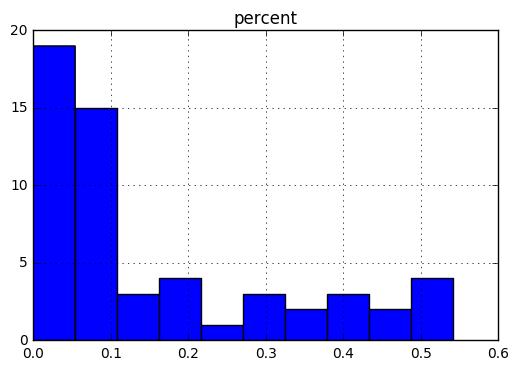

In [27]:
poverty_by_tract['percent'] = poverty_by_tract.apply(
    lambda row: float(row['B17009_002E']) / float(row['B01003_001E']), axis=1)

poverty_by_tract.hist(column="percent")

This histogram shows the count of census tracts in Alachua county that have each corresponding percent of the population living below the poverty line.

You can see that the calls to the census package and even the data formating are just a few lines of code however you still need to know quite a lot about how census data is represented in order to use the Python package.

## Second - What to do if there is no package

### Obtaining Gaineville Regional Utilities (GRU) billing data by directly calling Socrata's web API

Not all APIs have packages that wrap them. Sometimes, like [Socrata's package](https://pypi.python.org/pypi/sodapy), they exist but don't include the methods you want in your programming language of choice.

When someone makes a web-based API, you can interact with it using HTTP requests from Python with the [requests library](http://docs.python-requests.org/en/master/). This is a very full-featured library that will make using the complex parts of the HTTP protocol like data encoding, HTTPS, and authentication very easy.

Let's look at how to interact with a web API without a package. We will need to determine four things to get started:

1. The API access point. This is the URL where the API requests need to be sent to.
1. The API methods. These are often called endpoints and in REST APIs.
1. Method parameters that contain any data the methods need to do their job.
1. The format of the returned data.

For the Socrata API, the API access point is the server run by the City of Gainesville:

In [10]:
api_access_point = "https://data.cityofgainesville.org"

This is a simple API so the method in this case is just the name of the data set that you want to retieve data from. In other APIs these can be action nouns like "get" or "delete" or might refer to more complicated operations like "map" etc. Notice that datasets are named with a unique string. This is the one for electicity usage by month. You can find these names by clicking the [API link on the dataset's page](https://data.cityofgainesville.org/Environment-Energy/GRU-Customer-Electric-Consumption/gk3k-9435).

In [11]:
method = "resource"

To get data, we put these all together into a whole URL that we can then retrieve. For the moment let's also add some additional parameters for year and month as well as a cap on how many records will be returned.

In [12]:
dataset = "9qim-t8hy"
year = "2016"
month = "January"

api_url = ("{0}/{1}/{2}.json?year={3}&month={4}&$limit=3"
    .format(api_access_point, method, dataset, year, month))
print(api_url)

https://data.cityofgainesville.org/resource/9qim-t8hy.json?year=2016&month=January&$limit=3


Try clicking that link in your browser and see what you get. It will be a bunch of text that looks like this:

```
[{"date":"2016-01-31T00:00:00.000","kwh_consumption":"352","location_1":{"type":"Point","coordinates":[-82.375402,29.634124]},"location_1_address":"3527 SW 20TH AVE","location_1_city":"GAINESVILLE","location_1_state":"FL","month":"January","servcity":"GAINESVILLE","serviceaddress":"3527 SW 20TH AVE APT 1022","year":"2016"}
,{"date":"2016-01-31T00:00:00.000","kwh_consumption":"687","location_1":{"type":"Point","coordinates":[-82.339142,29.671293]},"location_1_address":"2029 NW 13TH ST","location_1_city":"GAINESVILLE","location_1_state":"FL","month":"January","servcity":"GAINESVILLE","serviceaddress":"2029 NW 13TH ST APT B-103","year":"2016"}
,{"date":"2016-01-31T00:00:00.000","kwh_consumption":"1113","location_1":{"type":"Point","coordinates":[-82.34493,29.68225]},"location_1_address":"3215 1 2 NW 17TH ST","location_1_city":"GAINESVILLE","location_1_state":"FL","month":"January","servcity":"GAINESVILLE","serviceaddress":"3215 1/2 NW 17TH ST","year":"2016"}]
```

This looks a lot like the Python code you would use to make a list of dictionaries. In fact it IS valid Python code and that is by design. It is a data interchange format called [JSON](http://www.json.org/) data, Javascript Object Notation. This is a way of representing simple data structures as text in a very compact manner that can be used by many programing languages to make usable variables. It supports arrays and objects for structures and strings and numbers for data types.

Notice that the output starts with a "[". This indicates that you are getting a list. The next character is a "{" which starts an object so you are getting a list of objects. The remaining strings in quotes separated by colons ":" are the propery names and values in the object.

Remember though that JSON is text, we still have to parse it into Python variables. To do that, we'll start by using the ```requests``` library to get the text and then we'll use a method of the library to convert the JSON into a Python list of dictionaries.

In [13]:
import requests
r = requests.get(api_url)
gru_data = r.json()

print(type(gru_data))
print(gru_data)

<type 'list'>
[{u'location_1': {u'type': u'Point', u'coordinates': [-82.375402, 29.634124]}, u'kwh_consumption': u'352', u'month': u'January', u'serviceaddress': u'3527 SW 20TH AVE APT 1022', u'location_1_address': u'3527 SW 20TH AVE', u'year': u'2016', u'date': u'2016-01-31T00:00:00.000', u'servcity': u'GAINESVILLE', u'location_1_state': u'FL', u'location_1_city': u'GAINESVILLE'}, {u'location_1': {u'type': u'Point', u'coordinates': [-82.339142, 29.671293]}, u'kwh_consumption': u'687', u'month': u'January', u'serviceaddress': u'2029 NW 13TH ST APT B-103', u'location_1_address': u'2029 NW 13TH ST', u'year': u'2016', u'date': u'2016-01-31T00:00:00.000', u'servcity': u'GAINESVILLE', u'location_1_state': u'FL', u'location_1_city': u'GAINESVILLE'}, {u'location_1': {u'type': u'Point', u'coordinates': [-82.34493, 29.68225]}, u'kwh_consumption': u'1113', u'month': u'January', u'serviceaddress': u'3215 1/2 NW 17TH ST', u'location_1_address': u'3215 1 2 NW 17TH ST', u'year': u'2016', u'date': u'

This looks like what we got back from the ```census``` package before. 

You can also see that nesting data is allowed:

In [14]:
print(gru_data[0]["location_1"])

{u'type': u'Point', u'coordinates': [-82.375402, 29.634124]}


With the census package we took this list of dictionaries and used a Pandas method to convert it to a data frame. However, requesting simple URLs and getting JSON back is such a common pattern that it's baked in to the Pandas library. You don't need the requests library although requests lets you intereact with much more complex APIs.

In [15]:
gru_dataframe = pd.read_json(api_url)
gru_dataframe.head(2)

,date,kwh_consumption,location_1,location_1_address,location_1_city,location_1_state,month,servcity,serviceaddress,year
0,2016-01-31,352,"{u'type': u'Point', u'coordinates': [-82.37540...",3527 SW 20TH AVE,GAINESVILLE,FL,January,GAINESVILLE,3527 SW 20TH AVE APT 1022,2016
1,2016-01-31,687,"{u'type': u'Point', u'coordinates': [-82.33914...",2029 NW 13TH ST,GAINESVILLE,FL,January,GAINESVILLE,2029 NW 13TH ST APT B-103,2016


At this point we can go on to analyze and graph things. For an example of making graphs of electrical usage by household address, you can look at [this notebook](https://github.com/mjcollin/gnv_data/blob/master/gru_graph.ipynb).

## Third - Options for getting data when there is no API

### Web scraping

Sometimes you can't win. Data may be publicly availible but not through an API or a package. In these cases you will need to get creative. One technique is to scrape web pages by picking out tables or formatted text and making data out of it. [Srapy](https://scrapy.org/) is powerful Python package for doing that.

Scraping is an involved task and worth its own workshop.

### URL hacking

Another technique is to find a common pattern in web URLs and incriment or change part of the URL with a loop in Python to walk through a whole dataset. As an example, you can see that this URL for publications hosted on the Internet Archive use the barcode "CAT31293222" as part of the URL:

[http://www.archive.org/download/CAT31293222/CAT31293222_files.xml](http://www.archive.org/download/CAT31293222/CAT31293222_files.xml)

There is a corresponding database dump that has all of the barcodes for all the images in the Biodiversity Heritage Library. By looping though the database and construting URLs like above, [you can download all the images](https://github.com/bio-guoda/guoda-datasets/blob/master/BHL/fetch_files.py).


### Obtaining Property Appraiser Data Through Manual Downloads from www.acpafl.org


You may also find data is availible in a nice format but the provider has limited what you can download, usually because they don't want their servers to be overloaded. If you want to work around this, please be considerate and limit what you take and also keep a copy locally so you don't have to keep going back to their servers.

The [Alachua County Property Appraiser](http://www.acpafl.org/advancedpropertysearch.asp) provides tax value and ownership information of all the properties in the county on their web site. But they limit downloads to only 5000 records and there isn't a nice URL pattern to use to script downloading more. To get a significant amount of data, pick some parameter that you can incriment in your search queries to make sure you get all records. In this example, I downloaded all single family residences (land use code 00100) in the 32605 zip code in batches by assessed value increments.

We can read the CSV files into dataframes and concatenate them.

In [16]:
data1 = pd.read_csv("data/32605_00100_0k_50k.csv")
data2 = pd.read_csv("data/32605_00100_50k_100k.csv")
data3 = pd.read_csv("data/32605_00100_100k_200k.csv")
data4 = pd.read_csv("data/32605_00100_200k_300k.csv")
data5 = pd.read_csv("data/32605_00100_300k_999k.csv")


appraiser_data = pd.concat([data1, data2, data3, data4, data5])
appraiser_data.head()

,Parcel_Num,Owner_Mail_Name,Owner_Mail_CO,Owner_Mail_Addr1,Owner_Mail_Addr2,Owner_Mail_City,Owner_Mail_State,Owner_Mail_Zip,Section,Township,...,School_Exempt_Amount,Tax_Amount,Loc_Address,Sale_Date,Sale_Price,Sale_VacImp,Sale_Qualified,Sale_Book,Sale_Page,Sale_Instrument
0,02048-000-000,"MITCHELL, ROSA LEE HEIRS",NaN,% SHIRLEY WASHINGTON,3304 NW 46TH PL,GAINESVILLE,FL,32605,4,10,...,0.0,978.05,25038 NW 3RD AV,01/26/1999,100.0,I,U,2273,2430.0,QD
1,02404-001-000,"COX, SANDRA",NaN,2535 NW 49TH PL,NaN,GAINESVILLE,FL,32605,4,10,...,0.0,789.83,25209 NW 7TH AV,01/18/2008,24000.0,I,U,3739,16.0,SD
2,03235-013-000,"BRILL, JUDITH",NaN,911 NW 37TH DR,NaN,GAINESVILLE,FL,32605,14,8,...,0.0,703.08,15610 NW 133RD TER,07/28/2015,14200.0,I,U,4370,1878.0,SD
3,04228-000-000,"DEGNER, R L & JANET D",NaN,2842 NW 28TH PL,NaN,GAINESVILLE,FL,32605-2705,27,9,...,0.0,1169.14,14821 NW 21ST AV,11/24/1990,28500.0,I,U,1799,1138.0,WD
4,04463-003-000,STRICKLAND R F,NaN,% FLORIDA REHAB,6700 NW 10TH PL,Gainesville,FL,32605,20,10,...,26000.0,359.89,5006 SW 170TH ST,03/01/1988,25000.0,I,Q,1694,2347.0,SD


And then we can make a quick histogram of the number of houses by total square footage.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000BCD9B70>]], dtype=object)

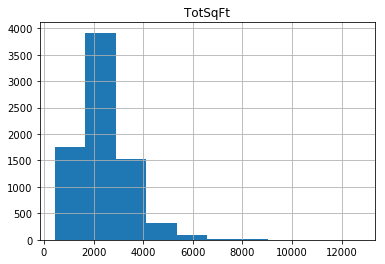

In [17]:
appraiser_data.hist("TotSqFt")

## Forth - Data APIs to transform data

### Geocoding Residences with Google's Service With the geocoder Package

Data APIs don't have to just be a source of downloading data, they can perform transformations and calcualtions as well.

The appariser data above does not have latitude and longitude in it so we can't plot it on a map. The process of converting a street address into map coordinates is called geocoding and there are many APIs for doing it. There is a Python package called [geocoder](https://pypi.python.org/pypi/geocoder) that wraps many of them up in to an easy to use interface. We will use it with the Google geocoding API to map some of the addresses.

As with the census API, the first step is to get an [API key from Google](https://developers.google.com/maps/documentation/geocoding/get-api-key) and save it to a file named ```google.key```.

In [20]:
google_api_key = read_key("google.key")

Then load the ```geocoder``` package and try it out with a test address.

In [21]:
# Before running you will need to install the 'census' package with
# pip install geocoder
import geocoder

g = geocoder.google("1604 NW 21ST AVE GAINESVILLE FL 32605-4062", 
                    key=google_api_key)
g.json

{'accuracy': u'ROOFTOP',
 'address': u'1604 NW 21 Ave, Gainesville, FL 32605, USA',
 'bbox': {'northeast': [29.6736079802915, -82.3409870197085],
  'southwest': [29.6709100197085, -82.34368498029151]},
 'city': u'Gainesville',
 'confidence': 9,
 'country': u'US',
 'county': u'Alachua County',
 'encoding': 'utf-8',
 'housenumber': u'1604',
 'lat': 29.672259,
 'lng': -82.342336,
 'location': '1604 NW 21ST AVE GAINESVILLE FL 32605-4062',
 'ok': True,
 'place': u'ChIJJQ6ZKWOk6IgRTTtpZvrFbxA',
 'postal': u'32605',
 'provider': 'google',
 'quality': u'street_address',
 'state': u'FL',
 'status': 'OK',
 'status_code': 200,
 'street': u'NW 21 Ave'}

You can see that the library takes a string that is the street address and returns JSON that contains a lat and lng property.

In order to do this to our data frame, we will first make a smaller dataframe with only a few rows. Google limits their API usage to 2000 requests per day. Then we will write a geocoding function and apply it to the dataframe to make a new column of the responses from the geocoding API. Finally we will pull the lat and lng out of those responses into thier own columns.

In [22]:
small_data = appraiser_data[appraiser_data["City_Desc"] == "Gainesville"].head()

def run_geocode(address):
    g = geocoder.google(address, key=google_api_key)
    return g.json

small_data["geocode_response"] = small_data.apply(lambda row: run_geocode(" ".join(
            [row["Loc_Address"], row["City_Desc"], "FL", "USA"])), axis=1)

small_data["lat"] = small_data.apply(lambda row: row["geocode_response"]["lat"], axis=1)
small_data["lng"] = small_data.apply(lambda row: row["geocode_response"]["lng"], axis=1)

In [23]:
small_data.head()

,Parcel_Num,Owner_Mail_Name,Owner_Mail_CO,Owner_Mail_Addr1,Owner_Mail_Addr2,Owner_Mail_City,Owner_Mail_State,Owner_Mail_Zip,Section,Township,...,Sale_Date,Sale_Price,Sale_VacImp,Sale_Qualified,Sale_Book,Sale_Page,Sale_Instrument,geocode_response,lat,lng
7,06014-001-088,MACLEAN & WORLEY,NaN,4232 NW 19TH ST,NaN,GAINESVILLE,FL,32605-1859,13,9,...,05/20/2003,23900.0,I,U,2738,1194.0,DD,"{u'encoding': u'utf-8', u'status_code': 200, u...",29.688119,-82.356258
8,06083-013-029,WALKER C D & SANDRA,NaN,3326 NW 46TH AVE,NaN,GAINESVILLE,FL,32605-1158,24,9,...,08/01/1987,76000.0,I,Q,1676,782.0,WD,"{u'neighborhood': u'Northwood', u'encoding': u...",29.697030,-82.371809
9,06105-088-000,JACOBSON BARRY M & ELAINE M,NaN,2436 NW 37TH TER,NaN,GAINESVILLE,FL,32605,26,9,...,08/31/2001,150000.0,I,Q,2384,1021.0,WD,"{u'status': u'OK', u'city': u'Gainesville', u'...",29.675822,-82.379596
10,06107-839-075,"DINH, KHANH",NaN,7819 NW 22ND LN,NaN,GAINESVILLE,FL,32605,26,9,...,09/25/2013,57500.0,I,Q,4230,705.0,WD,"{u'status': u'OK', u'city': u'Gainesville', u'...",29.678190,-82.385011
19,06424-003-000,BERNARD TAMMY L,NaN,1621 NW 26TH WAY,NaN,GAINESVILLE,FL,32605-3860,36,9,...,05/27/1997,136000.0,I,Q,2113,2591.0,WD,"{u'neighborhood': u'Brywood, Fox Grove & The M...",29.667425,-82.361601


We can map these points using basemap or other Python packages. We'll use a shape file of the census tracts as a background.

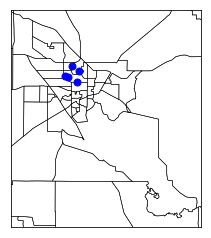

In [25]:
# Before running you will need to install the 'basemap' package with
# conda install basemap
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

my_map = Basemap(llcrnrlon=-82.5,llcrnrlat=29.4,urcrnrlon=-82.1,urcrnrlat=29.8,
             resolution='i', projection='tmerc', lat_0 = 29.65, lon_0 = -82.33)
my_map.readshapefile("data/gz_2010_12_140_00_500k", "census_tracts")


x,y = my_map(small_data["lng"].tolist(), small_data["lat"].tolist())

my_map.plot(x, y, 'bo', markersize=7)

plt.show()